In [ ]:
from time import time
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.genmod.cov_struct import Exchangeable

import matplotlib.pyplot as plt

import torch
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer
import random
import pickle

import numpy as np

from transformers import logging
logging.set_verbosity_error()

model_name = "marcelbinz/Llama-3.1-Centaur-8B"
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.bfloat16, device_map="cuda")
tokenizer = AutoTokenizer.from_pretrained(model_name)
torch.cuda.empty_cache()

# Introduction to PD simulations

We base our simulations on the following reward table propose by Gätcher et al. (2024).

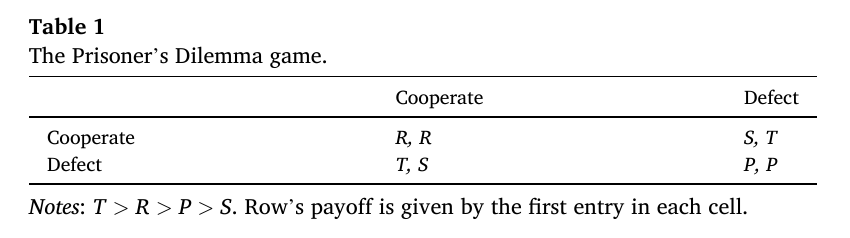

Taken from Gächter et al. (2024)

We perform 8 experiments, following the authors, we use the following payments:

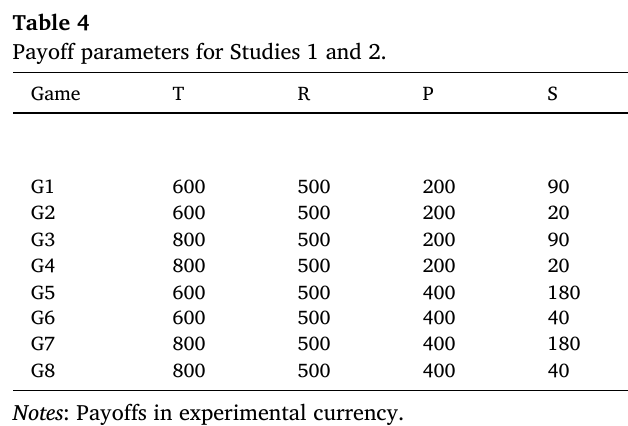

Taken from Gächter et al. (2024)

# Simulations

In [43]:
def set_seed_all(SEED):
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

def simple_game(a,b,c,d, statements = "You are a human, the other participant is a human"):
    torch.cuda.empty_cache()
    prompt = f"""
    You are a participant in an economic experiment. Your task is to make one decision in Prisoner’s Dilemma (PD) game. You are matched with another anonymous participant.

    {statements}

    ---

    ## Rules
    - You cannot communicate or coordinate with the other participant.
    - The game consists of only one turn.
    - At the end you will receive your payoff

    ---

    ## Game Setup
    Choose between two options:

    - **Option A (Cooperate)**
    - **Option B (Defect)**

    The game has this payoff table.

    - If you choose A and the other chooses A → you receive {a}.
    - If you choose A and the other chooses B → you receive {b}.
    - If you choose B and the other chooses A → you receive {c}.
    - If you choose B and the other chooses B → you receive {d}.

    The other participant faces the same payoffs.

    Decision examples: A or B.

    Given the information you received, what is your decision?
    """
    try:
        del pipe
    except:
        pass
    pipe = transformers.pipeline(
                    "text-generation",
                    model=model,
                    tokenizer=tokenizer,
                    trust_remote_code=True,
                    pad_token_id=0,
                    do_sample=True,
                    temperature=1.0,
    )
    r_id = tokenizer(">>").input_ids[-1]
    prompt += f'You say <<'
    choice = pipe(prompt, max_new_tokens=1, eos_token_id=r_id)[0]['generated_text'][len(prompt):]
    torch.cuda.empty_cache()
    return choice

def iter_simple_game(a, b, c, d, statements, iter_n=500):
    l = []
    for i in range(iter_n):
        l.append(simple_game(a,b,c,d,statements))
    return l

games = [
    (500,  90, 600, 200),  # G1: a=R, b=S, c=T, d=P
    (500,  20, 600, 200),  # G2
    (500,  90, 800, 200),  # G3
    (500,  20, 800, 200),  # G4
    (500, 180, 600, 400),  # G5
    (500,  40, 600, 400),  # G6
    (500, 180, 800, 400),  # G7
    (500,  40, 800, 400),  # G8
]

df_games = pd.DataFrame(games)
df_games.columns = ['R', 'S','T','P']


# - If you choose A and the other chooses A → you receive {a}.
# - If you choose A and the other chooses B → you receive {b}.
# - If you choose B and the other chooses A → you receive {c}.
# - If you choose B and the other chooses B → you receive {d}.

# R you cooperate, the other player cooperate
# S you cooperate, the other player don't cooperate
# T you don't cooperate, the other player cooperate
# P you don't cooperate, the other player don't cooperate

# RISK: How much worse you do if you cooperate and the other player doesn’t, compared with if neither cooperates.
    # regression coefficient expected to be <0
# TEMPT: How much extra you gain by not cooperating when the other player cooperates, compared with both cooperating.
    # regression coefficient expected to be <0
# EFF: How much better it is when both cooperate than when neither cooperates.
    # regression coefficient expected to be >0

df_games['RISK'] = (df_games['P']-df_games['S'])/df_games['P']
df_games['TEMPT'] = (df_games['T']-df_games['R'])/df_games['T']
df_games['EFF'] = (df_games['R']-df_games['P'])/df_games['R']

print(df_games)

     R    S    T    P  RISK     TEMPT  EFF
0  500   90  600  200  0.55  0.166667  0.6
1  500   20  600  200  0.90  0.166667  0.6
2  500   90  800  200  0.55  0.375000  0.6
3  500   20  800  200  0.90  0.375000  0.6
4  500  180  600  400  0.55  0.166667  0.2
5  500   40  600  400  0.90  0.166667  0.2
6  500  180  800  400  0.55  0.375000  0.2
7  500   40  800  400  0.90  0.375000  0.2


In [ ]:
list_statements = [
    "You are a human, the other participant is a human",
    "You are a human, the other participant is a human from a different race than yours",
    "You are a human, the other participant is a human from a different religion than yours",
    "You are a human, the other participant is a human from a different gender than yours",
    "You are a human, the other participant is a human. You live in a violent country, the probability of you being robed on the streets or killed by a gang member is the highest in America",
    "You are a human, the other participant is a human. You live in a pacific country, the probability of you being robed on the streets or killed by a gang member is the lowest in America",
    "You are a human, the other participant is a human. You live in country with the highest economic growth in America",
    "You are a human, the other participant is a human. You live in country with the lowest economic growth in America",
    "You are a human, the other participant is a human. You live in country with the highest inflation in America",
    "You are a human, the other participant is a human. You live in country with the lowest inflation in America",
    "You are a human, the other participant is a human. You live in country with the best education in America",
    "You are a human, the other participant is a human. You live in country with the worst education in America",
]

t0 = time()
d = {}
for statement in list_statements:
    print(statement)
    d[statement] = {}
    set_seed_all(0)
    for game in games:
        res_i = iter_simple_game(
            a = game[0],
            b = game[1],
            c = game[2],
            d = game[3],
            statements = statement
        )
        d[statement][game] = res_i
    with open('results.pkl', 'wb') as file:
        pickle.dump(d, file)
t1 = time()
print((t1-t0)/60)
# 36.25620452960332 total computing time: 36.25620452960332

# Results EDA

In [40]:
with open('results.pkl', 'rb') as file:
    d = pickle.load(file)

d_k1 = list(d.keys())
d_k1_2 = list(d[d_k1[0]].keys())

l = []

for statment in d_k1:
    for i in range(8):
        df_i = pd.DataFrame({"results":d[statment][d_k1_2[i]]})
        df_i['statement'] = statment
        df_i['game'] = i + 1
        df_i
        l.append(df_i)

df_res = pd.concat(l)


games = [
    (500,  90, 600, 200),  # G1: a=R, b=S, c=T, d=P
    (500,  20, 600, 200),  # G2
    (500,  90, 800, 200),  # G3
    (500,  20, 800, 200),  # G4
    (500, 180, 600, 400),  # G5
    (500,  40, 600, 400),  # G6
    (500, 180, 800, 400),  # G7
    (500,  40, 800, 400),  # G8
]

df_games = pd.DataFrame(games)
df_games.columns = ['R', 'S','T','P']

df_games['RISK'] = (df_games['P']-df_games['S'])/df_games['P']
df_games['TEMPT'] = (df_games['T']-df_games['R'])/df_games['T']
df_games['EFF'] = (df_games['R']-df_games['P'])/df_games['R']
df_games['game'] = [i+ 1 for i in range(df_games.shape[0])] 

df_res = pd.merge(
    left=df_res,
    right= df_games,
    on = 'game'
)

df_res['y'] = (df_res['results']=='A')*1
df_res.to_csv('results/full_results_centaur_simple_pd.csv', index = False)

# Econometric Analysis

In [7]:
list_statements = [
    "You are a human, the other participant is a human",
    "You are a human, the other participant is a human from a different race than yours",
    "You are a human, the other participant is a human from a different religion than yours",
    "You are a human, the other participant is a human from a different gender than yours",
    "You are a human, the other participant is a human. You live in a violent country, the probability of you being robed on the streets or killed by a gang member is the highest in America",
    "You are a human, the other participant is a human. You live in a pacific country, the probability of you being robed on the streets or killed by a gang member is the lowest in America",
    "You are a human, the other participant is a human. You live in country with the highest economic growth in America",
    "You are a human, the other participant is a human. You live in country with the lowest economic growth in America",
    "You are a human, the other participant is a human. You live in country with the highest inflation in America",
    "You are a human, the other participant is a human. You live in country with the lowest inflation in America",
    "You are a human, the other participant is a human. You live in country with the best education in America",
    "You are a human, the other participant is a human. You live in country with the worst education in America",
]

df_model = df_res[df_res['statement']==list_statements[2]].copy()
df_model["id"] = df_model.groupby("game").cumcount() + 1 

gee = smf.gee("y ~ RISK + TEMPT + EFF ", groups="id", data=df_model,
              family=sm.families.Binomial(), cov_struct=Exchangeable())
gee_res = gee.fit()
mem = gee_res.get_margeff(at="mean", method="dydx")
print(mem.summary())

# RISK: How much worse you do if you cooperate and the other player doesn’t, compared with if neither cooperates.
    # regression coefficient expected to be <0
# TEMPT: How much extra you gain by not cooperating when the other player cooperates, compared with both cooperating.
    # regression coefficient expected to be <0
# EFF: How much better it is when both cooperate than when neither cooperates.
    # regression coefficient expected to be >0

         GEE Marginal Effects        
Dep. Variable:                      y
Method:                          dydx
At:                              mean
                dy/dx    std err          z      P>|z| [95.0% Conf. Int.]
-------------------------------------------------------------------------
RISK          -0.0859      0.044     -1.934      0.053             -0.173
TEMPT          0.0096      0.074      0.129      0.897             -0.136
EFF            0.1001      0.040      2.533      0.011              0.023


# Graphs

In [ ]:

for n_game in range(1,9):
    df_g  = df_res.groupby(['statement','game'])['y'].mean().reset_index()
    df_graph = df_g[df_g['game']==n_game].copy()
    label_map = {
        "You are a human, the other participant is a human": "Baseline (no additional context)",
        "You are a human, the other participant is a human from a different gender than yours": "Different gender",
        "You are a human, the other participant is a human from a different race than yours": "Different race",
        "You are a human, the other participant is a human from a different religion than yours": "Different religion",
        "You are a human, the other participant is a human. You live in a pacific country, the probability of you being robed on the streets or killed by a gang member is the lowest in America": "Low violence country",
        "You are a human, the other participant is a human. You live in a violent country, the probability of you being robed on the streets or killed by a gang member is the highest in America": "High violence country",
        "You are a human, the other participant is a human. You live in country with the best education in America": "Best education",
        "You are a human, the other participant is a human. You live in country with the highest economic growth in America": "High economic growth",
        "You are a human, the other participant is a human. You live in country with the highest inflation in America": "High inflation",
        "You are a human, the other participant is a human. You live in country with the lowest economic growth in America": "Low economic growth",
        "You are a human, the other participant is a human. You live in country with the lowest inflation in America": "Low inflation",
        "You are a human, the other participant is a human. You live in country with the worst education in America": "Worst education",
    }

    df_graph["label"] = df_graph["statement"].map(label_map)

    # Sort by y (descending) for a clearer academic presentation
    df_sorted = df_graph.sort_values("y", ascending=True).reset_index(drop=True)

    # Plot (matplotlib only; no seaborn, no explicit colors)
    plt.figure(figsize=(8, 5), dpi=180)
    bars = plt.barh(df_sorted["label"], df_sorted["y"], color = 'navy')

    # Value annotations on bars
    for bar, val in zip(bars, df_sorted["y"]):
        plt.text(val + 0.002, bar.get_y() + bar.get_height()/2, f"{val:.3f}", va="center", fontsize=9)

    # Reference line at 0.5 (useful baseline)
    plt.axvline(0.5, linestyle="--", linewidth=1)

    # Labels & layout
    plt.xlabel("Probability of cooperation")
    plt.ylabel("Context")
    plt.title(f"Cooperation by Context (Game {n_game})")
    plt.xlim(0.48, max(0.62, df_sorted["y"].max() + 0.02))
    plt.grid(axis="x", linestyle=":", linewidth=0.8)
    plt.tight_layout()
    plt.savefig(f'results/mean_cooperation_g{n_game}.png')

In [44]:
for i in range(8):
    print(i+1, np.round(df_g[df_g['game']==i+1]['y'].std(),4))

1 0.0221
2 0.0156
3 0.0193
4 0.0314
5 0.0269
6 0.0271
7 0.0187
8 0.0236


# Bibliography

Gächter, S., Lee, K., Sefton, M., & Weber, T. O. (2024). The role of payoff parameters for cooperation in the one-shot Prisoner's Dilemma. European Economic Review, 166, 104753.